# Imports

In [1]:
import random
import os
import time

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
        
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras import Sequential
from keras.applications import VGG19, VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Flatten, Dense, BatchNormalization, Activation,Dropout

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

# Hyperparameters

In [2]:
VALIDATION_DIR = r'./data/validation/'
TRAINING_DIR = r'./data/train/'

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 100
LEARNING_RATE = 0.001

# Data Preprocessing

In [3]:
black = os.path.join(TRAINING_DIR, 'black')
blue = os.path.join(TRAINING_DIR, 'blue')
brown = os.path.join(TRAINING_DIR, 'brown')
green = os.path.join(TRAINING_DIR, 'green')
grey = os.path.join(TRAINING_DIR, 'grey')
orange = os.path.join(TRAINING_DIR, 'orange')
pink = os.path.join(TRAINING_DIR, 'pink')
purple = os.path.join(TRAINING_DIR, 'purple')
red = os.path.join(TRAINING_DIR, 'red')
silver = os.path.join(TRAINING_DIR, 'silver')
white = os.path.join(TRAINING_DIR, 'white')
yellow = os.path.join(TRAINING_DIR, 'yellow')

black_files = os.listdir(black)
blue_files = os.listdir(blue)
brown_files = os.listdir(brown)
green_files = os.listdir(green)
grey_files = os.listdir(grey)
orange_files = os.listdir(orange)
pink_files = os.listdir(pink)
purple_files = os.listdir(purple)
red_files = os.listdir(red)
silver_files = os.listdir(silver)
white_files = os.listdir(white)
yellow_files = os.listdir(yellow)

all_files = {
    'black':black_files,
    'blue':blue_files,
    'brown':brown_files,
    'green':green_files,
    'grey':grey_files,
    'orange':orange_files,
    'pink':pink_files,
    'purple':purple_files,
    'red':red_files,
    'silver':silver_files,
    'white':white_files,
    'yellow':yellow_files
}

Directory structure for train images

In [4]:
total_train_images = 0

colours = []
images = []
for dirpath, dirnames, filenames in os.walk(TRAINING_DIR):
    total_train_images += len(filenames)
    colours.append(dirpath.split('/')[-1])
    images.append(len(filenames))
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print(f"There are {total_train_images} images in training set")

There are 12 directories and 0 images in './data/train/'.
There are 0 directories and 302 images in './data/train/black'.
There are 0 directories and 576 images in './data/train/blue'.
There are 0 directories and 581 images in './data/train/brown'.
There are 0 directories and 635 images in './data/train/green'.
There are 0 directories and 686 images in './data/train/grey'.
There are 0 directories and 282 images in './data/train/orange'.
There are 0 directories and 285 images in './data/train/pink'.
There are 0 directories and 287 images in './data/train/purple'.
There are 0 directories and 613 images in './data/train/red'.
There are 0 directories and 287 images in './data/train/silver'.
There are 0 directories and 623 images in './data/train/white'.
There are 0 directories and 355 images in './data/train/yellow'.
There are 5512 images in training set


Directory structure for validation images

In [5]:
total_val_images = 0
for dirpath, dirnames, filenames in os.walk(VALIDATION_DIR):
    total_val_images += len(filenames)
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print(f"There are {total_val_images} validation set")

There are 12 directories and 0 images in './data/validation/'.
There are 0 directories and 40 images in './data/validation/black'.
There are 0 directories and 63 images in './data/validation/blue'.
There are 0 directories and 51 images in './data/validation/brown'.
There are 0 directories and 60 images in './data/validation/green'.
There are 0 directories and 56 images in './data/validation/grey'.
There are 0 directories and 73 images in './data/validation/orange'.
There are 0 directories and 68 images in './data/validation/pink'.
There are 0 directories and 65 images in './data/validation/purple'.
There are 0 directories and 73 images in './data/validation/red'.
There are 0 directories and 63 images in './data/validation/silver'.
There are 0 directories and 83 images in './data/validation/white'.
There are 0 directories and 77 images in './data/validation/yellow'.
There are 772 validation set


# Data Visualization

In [6]:
colours

['',
 'black',
 'blue',
 'brown',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'white',
 'yellow']

In [7]:
images

[0, 302, 576, 581, 635, 686, 282, 285, 287, 613, 287, 623, 355]

In [8]:
train_colors = pd.Series(index=colours[1:], data=images[1:])
train_colors

black     302
blue      576
brown     581
green     635
grey      686
orange    282
pink      285
purple    287
red       613
silver    287
white     623
yellow    355
dtype: int64

## checking for class imbalance

We cant say perfectly balanced classes but they are not too much imbalnanced too

In [9]:
fig = px.bar(train_colors)
fig.show()

In [10]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

colors = ['orange', 'yellow', 'purple', 'silver', 'grey',
          'pink', 'black', 'blue', 'white', 'green', 'red', 'brown']


def show_random_image():
    random_color = random.choice(colors)
    images = all_files[random_color]
    img_path = random.choice(images)
    img_path = TRAINING_DIR + '/' + random_color+'/'+img_path
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(random_color)
    plt.axis('off')

## plot random images from the trainig set

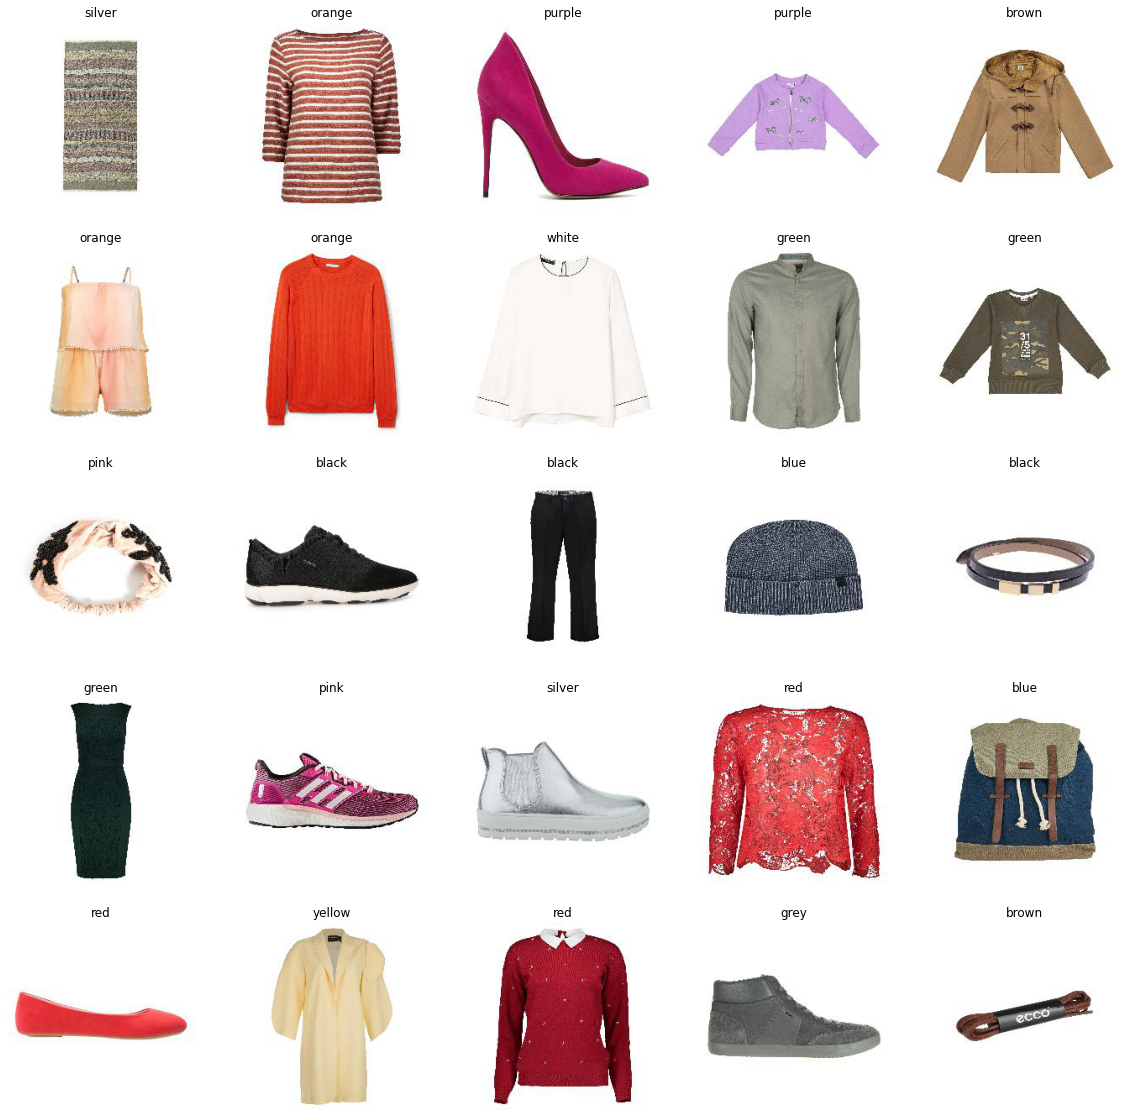

In [11]:
plt.figure(figsize=(20, 20))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    show_random_image()

# Training the model

In [12]:
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 5512 images belonging to 12 classes.
Found 772 images belonging to 12 classes.


## Using Transfer learning 

Using InceptionV3 model and using imagenet weights as starting point and training from that point

In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=(224, 224, 3),
                                include_top=False,
                                weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = True

pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [14]:
x = Flatten()(last_output)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
x = Dense(12, activation='softmax')(x)           

model = Model(pre_trained_model.input, x)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

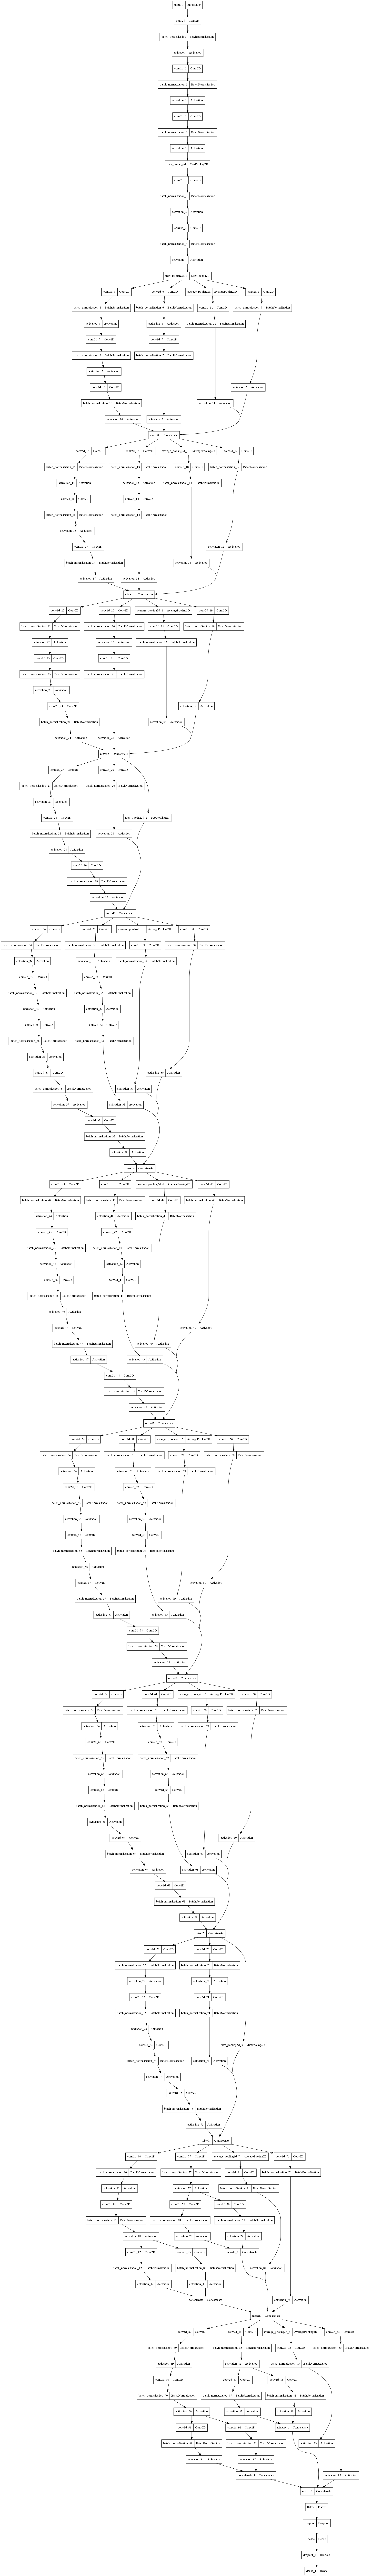

In [16]:
plot_model(model)

In [17]:
# learn_rate = LEARNING_RATE

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# cb = ModelCheckpoint('inceptionv3.h5', save_best_only=True)
# lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.1, patience=5, min_lr=1e-5)

# adam = Adam(learning_rate=learn_rate)
# model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])


# history = model.fit(train_generator, epochs=EPOCHS,
#                     validation_data=validation_generator, 
#                     callbacks=[es, cb, lrr])

model = tf.keras.models.load_model('inceptionv3.h5')

# Visualize model predictions

## model loss curves

In [18]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [19]:
# plot_loss_curves(history)

In [20]:
loss, accuracy = model.evaluate(validation_generator)

25/25 [==============================] - 8s 77ms/step - loss: 0.6828 - accuracy: 0.8044


In [21]:
print(f"Model Loss is {loss} and Accuracy is {100*np.round(accuracy, 4)}%")

Model Loss is 0.6827940344810486 and Accuracy is 80.44%


## Prediction on validation Images

In [22]:
classes = list(train_generator.class_indices.keys())

In [23]:
def predict_val_image(index):
    predictions =  model.predict(val_images, verbose=0)[index]
    true_label = classes[val_labels[index].argmax()]
    predicted_label = classes[predictions.argmax()] 

    if(true_label== predicted_label):
        color = 'green'  
    else:
        color = 'red'

    plt.title(f"True : {true_label} Predicted: {predicted_label}", color=color)
    plt.imshow(val_images[index])
    plt.axis('off')

In [24]:
classes

['black',
 'blue',
 'brown',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'white',
 'yellow']

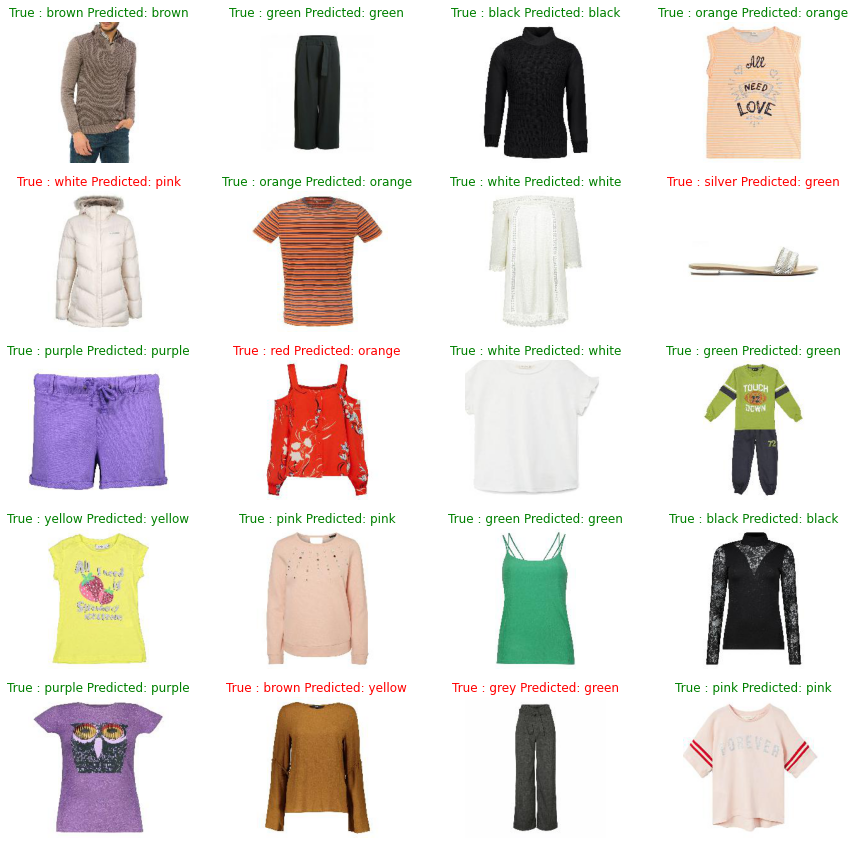

In [25]:
val_images, val_labels = validation_generator.next()
plt.figure(figsize=(15, 15))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    predict_val_image(i)

## Predictions on unseen test images

In [26]:
test_dir = r'./data/test/'

In [27]:
test_paths = []
for image in os.listdir(test_dir):
        test_paths.append(test_dir+'/'+image)

In [28]:
def predict_random_test_image():
    path = random.choice(test_paths)
    image = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    input_arr = input_arr.astype('float32') / 255.
    predictions = model.predict(input_arr, verbose=0)
    series = pd.Series(predictions[0], index=classes)
    predicted_classes = np.argsort(predictions)
    predictions.sort()
    plt.title(f"{classes[predicted_classes[0][-1]]} - {round(predictions[0][-1] * 100,2)}% \n{classes[predicted_classes[0][-2]]} - {round(predictions[0][-2] * 100,2)}% \n{classes[predicted_classes[0][-3]]} - {round(predictions[0][-2] * 100,3)}%")
    plt.imshow(image)
    plt.axis('off')

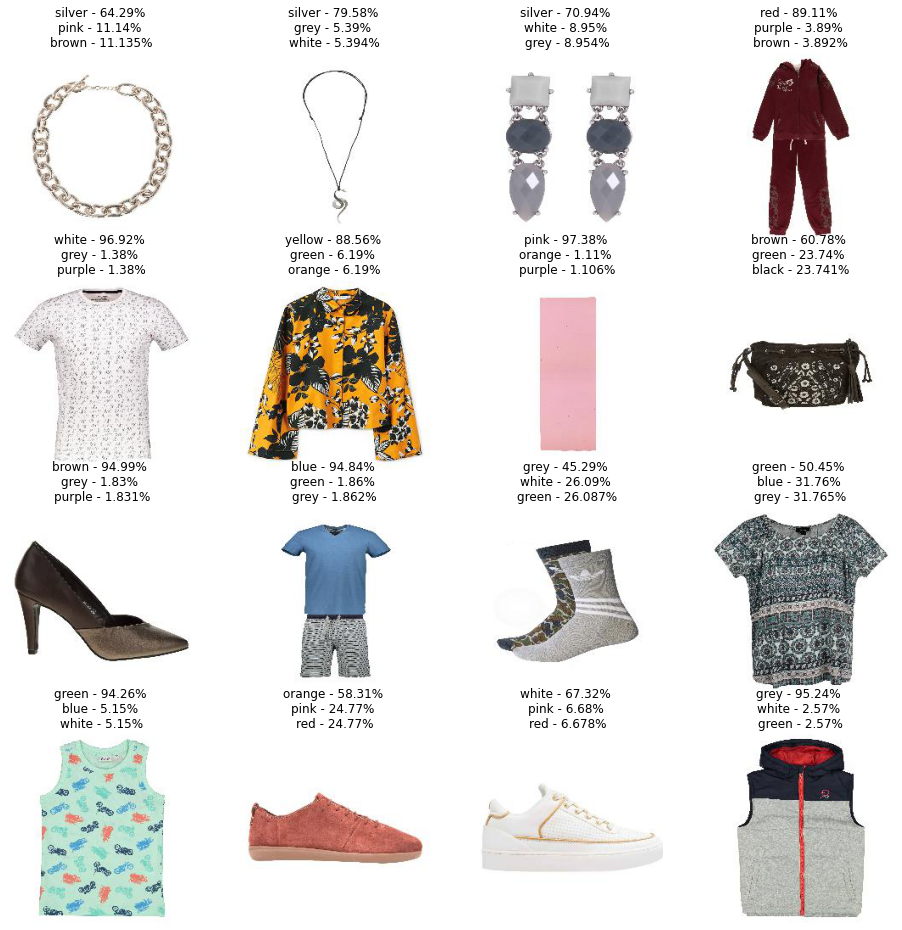

In [29]:
plt.figure(figsize=(16, 16))
plt.title("TOP 3 Predictions")
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    predict_random_test_image()

## Prediction on custom images

create a custom dataset

add any image you want to predict to the custom data set

In [34]:
custom_dir = r'./data/custom images/'

In [35]:
custom_paths = []
for image in os.listdir(custom_dir):
        custom_paths.append(custom_dir+'/'+image)

In [36]:
def predict_probabilities_custom_images(index):
    path = custom_paths[index]
    image = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    input_arr = input_arr.astype('float32') / 255.
    predictions = model.predict(input_arr)
    predicted_class = np.argmax(predictions, axis=-1)
    series = pd.Series(predictions[0], index=classes)
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.axis('off')
    plt.title(classes[predicted_class[0]])
    plt.show() 
    fig = px.bar(series)
    fig.show()

1/1 [==============================] - 0s 24ms/step


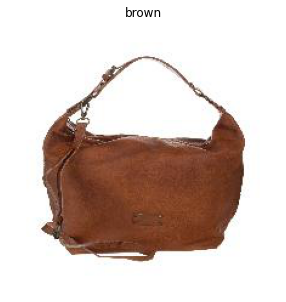

1/1 [==============================] - 0s 34ms/step


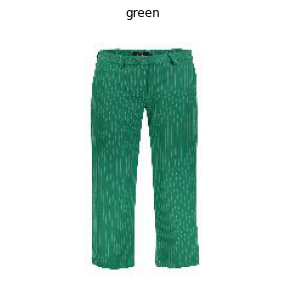

In [37]:
samples = 2
for i in range(samples):
    predict_probabilities_custom_images(i)